In [1]:
from IPython.core.display import display_html, HTML
display_html(HTML("<style>.container {width:80% !important; }</style>"))

# Лабораторная работа №5: Методы, основанные на деревьях решений. Регрессионные деревья. Деревья классификации. лучайный лес. Бустинг. Регуляризация логистической регрессии. <br>
## Вариант 15 <br>
## ПМИ3-1, Лязер Г.В.

## Список столбцов файла `default_of_credit_card_clients.csv` (исходные данные):

---
- LIMIT_BAL – размер выданного кредита (новых тайваньских долларов);
- SEX – пол: 1 = мужской, 2 = женский;
- EDUCATION – образование: 1 = аспирантура, 2 = университет, 3 = старшая школа, 4 = другое;
- MARRIAGE – семейное положение: 1 = женат/замужем, 2 = одинок, 3 = другое;
- AGE – возраст, лет;
- PAY_0, PAY_2, ..., PAY_6 – статус последних ежемесячных платежей, с сентября (PAY_0) по апрель (PAY_6) 2005 года: -1 = платёж внесён вовремя, 1 = платёж внесён с опозданием на 1 месяц; 2 = с опозданием на 2 месяца, и т.д., 9 = с опозданием на 9 месяцев и более;
- BILL_AMT1, ..., BILL_AMT6 – размер последних ежемесячных платежей (новых тайваньских долларов), с сентября (BILL_AMT1) по апрель (BILL_AMT6) 2005 года;
- PAY_AMT1, ..., PAY_AMT6 – размер ежемесячных платежей в предыдущем месяце (новых тайваньских долларов), с сентября (PAY_AMT1 за август) по апрель (PAY_AMT6 за март) 2005 года;
- Y – целевая переменная: дефолт в следующем месяце (1 – да, 0 – нет).
---

Метод построения модели: **Бустинг**

In [2]:
import numpy as np

import pandas as pd

import matplotlib as mpl

import seaborn as sns

import urllib

from pathlib import Path

from IPython.display import Markdown, display

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from scipy.stats import chi2_contingency

import time

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.model_selection import KFold, GridSearchCV

from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import classification_report

In [3]:
my_seed = 15

plt = mpl.pyplot

mpl.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

In [4]:
sns.color_palette('Set2')

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [5]:
def printmd(string : str):
	display(Markdown(string))

concat_func_md = lambda x, y: '`' + str(x) + "`:&ensp;&ensp;&ensp;&ensp;" + str(y)
concat_func = lambda x, y: str(x) + ' ' * 4 + str(y)

def plot_feature_importance(importance, names, model_type) :
	#Create arrays from feature importance and feature names
	feature_importance = np.array(importance)
	feature_names = np.array(names)

	#Create a DataFrame using a Dictionary
	data={'feature_names':feature_names,'feature_importance':feature_importance}
	fi_df = pd.DataFrame(data)
	#Sort the DataFrame in order decreasing feature importance
	fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
	#Define size of bar plot
	plt.figure(figsize=(10,8))
	#Plot Searborn bar chart
	sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
	#Add chart labels
	plt.title('Важность признаков в модели: ' + model_type)
	plt.xlabel('Важность признака')
	plt.ylabel('')

In [6]:
DF_raw = pd.read_csv('https://raw.githubusercontent.com/aksyuk/MTML/refs/heads/main/Labs/data/default_of_credit_card_clients.csv')

print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (30000, 24)


In [7]:
DF_raw.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Y            int64
dtype: object

In [8]:
DF_raw.isna().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
Y            0
dtype: int64

In [9]:
DF = DF_raw.sample(frac=0.85, random_state=my_seed)

DF_predict = DF_raw.drop(DF.index)

## Предварительный анализ данных

### Описательная статистика

In [10]:
num_vars = ['LIMIT_BAL', 'AGE'] + [col for col in DF.columns if any(x in col for x in ['BILL_', 'PAY_AMT'])]
cat_vars = [col for col in DF.columns if col not in num_vars]

In [11]:
for col in cat_vars:
	freq_col = DF[col].value_counts(dropna=False)
	str_freqs = np.around(freq_col / sum(freq_col), 3).astype(str)
	str_names = freq_col.index.values.astype(str)
	print('\n', col, '\n', '\n'.join(list(map(concat_func, str_names, str_freqs))))


 SEX 
 2    0.603
1    0.397

 EDUCATION 
 2    0.465
1    0.353
3    0.166
5    0.009
4    0.004
6    0.002
0    0.0

 MARRIAGE 
 2    0.53
1    0.458
3    0.011
0    0.002

 PAY_0 
 0    0.489
-1    0.189
1    0.124
-2    0.092
2    0.09
3    0.011
4    0.003
5    0.001
8    0.001
6    0.0
7    0.0

 PAY_2 
 0    0.523
-1    0.202
2    0.131
-2    0.126
3    0.011
4    0.003
1    0.001
5    0.001
7    0.001
6    0.0
8    0.0

 PAY_3 
 0    0.525
-1    0.198
-2    0.136
2    0.127
3    0.008
4    0.003
7    0.001
5    0.001
6    0.001
1    0.0
8    0.0

 PAY_4 
 0    0.548
-1    0.19
-2    0.145
2    0.104
3    0.006
4    0.002
7    0.002
5    0.001
6    0.0
8    0.0
1    0.0

 PAY_5 
 0    0.566
-1    0.183
-2    0.151
2    0.088
3    0.006
4    0.003
7    0.002
5    0.001
6    0.0
8    0.0

 PAY_6 
 0    0.544
-1    0.19
-2    0.163
2    0.092
3    0.006
4    0.002
7    0.002
6    0.001
5    0.0
8    0.0

 Y 
 0    0.779
1    0.221


In [12]:
str_freqs.astype(str)

Y
0    0.779
1    0.221
Name: count, dtype: object

In [13]:
np.around(DF[num_vars].describe(), 3)

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,25500.000,25500.000,25500.000,25500.000,25500.000,25500.000,25500.000,25500.000,25500.000,25500.000,25500.000,25500.000,25500.000,25500.000
mean,167607.137,35.524,51195.828,49147.973,46796.099,43168.749,40220.799,38804.968,5621.995,5781.955,5214.019,4784.862,4803.624,5242.383
std,129517.884,9.234,73529.824,70945.247,68468.523,64178.141,60679.249,59334.850,16414.783,20275.145,17129.286,15768.461,14958.986,18062.504
min,10000.000,21.000,-165580.000,-69777.000,-157264.000,-170000.000,-61372.000,-339603.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,50000.000,28.000,3476.500,2975.000,2643.000,2349.250,1759.000,1261.000,1000.000,824.000,390.000,284.750,246.000,109.750
50%,140000.000,34.000,22209.000,21059.000,19994.000,18983.000,18008.000,16970.000,2101.000,2007.000,1829.000,1500.000,1500.000,1500.000
75%,240000.000,42.000,67270.750,64088.000,59942.750,54217.750,50007.500,49235.750,5007.000,5000.000,4500.000,4003.000,4022.250,4000.000
max,800000.000,79.000,746814.000,743970.000,693131.000,706864.000,823540.000,699944.000,873552.000,1227082.000,889043.000,621000.000,426529.000,528666.000


### Распределение предикторов внутри классов по зависимой переменной

In [14]:
for col in cat_vars:
	con_tab = pd.crosstab(DF[col], DF['Y'])
	c, p, dof, expected = chi2_contingency(con_tab)
	if p > 0.05:
		print(col, 'и Y\nH_0: переменные распределены незавсимо друг от друга\nP-значение:', np.around(p, 4))

Получаем, что все категориальные переменнные имеют влияние на зависимую переменную.

### Визуализация разбросов переменных внуттри классов

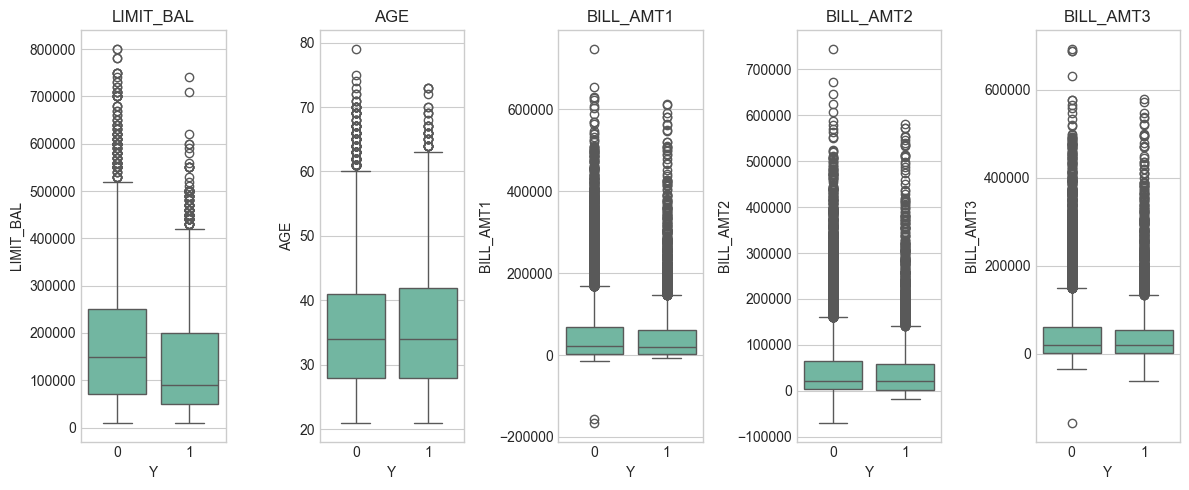

In [15]:
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF[num_vars].columns[:5].values)
for col_name in cols_loop :
	i = cols_loop.index(col_name)
	sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
	axs[i].set_ylabel(col_name)
	axs[i].set_title(col_name)

del i
gs.tight_layout(plt.gcf())
plt.show()

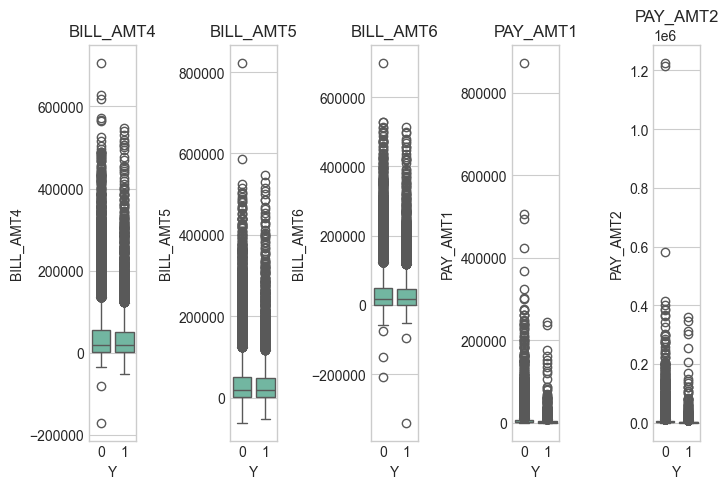

In [16]:
fig = plt.figure(figsize=(7.2, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])


axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF[num_vars].columns[5:10].values)
for col_name in cols_loop :
	i = cols_loop.index(col_name)
	sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
	axs[i].set_ylabel(col_name)
	axs[i].set_title(col_name)

gs.tight_layout(plt.gcf())
plt.show()

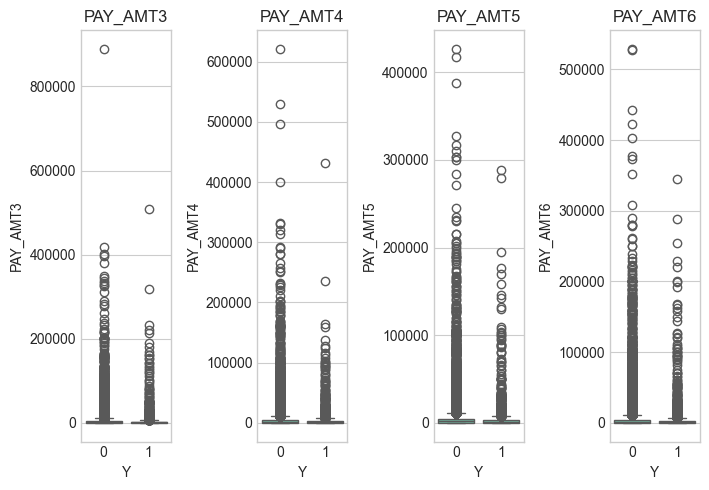

In [17]:
fig = plt.figure(figsize=(7.2, 5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])



axs = [ax1, ax2, ax3, ax4]

cols_loop = list(DF[num_vars].columns[10:].values)
for col_name in cols_loop :
	i = cols_loop.index(col_name)
	sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
	axs[i].set_ylabel(col_name)
	axs[i].set_title(col_name)

gs.tight_layout(plt.gcf())
plt.show()

### Перекодировка номинальной и порядковой шкалы

In [18]:
nom_col_names = ['SEX', 'EDUCATION', 'MARRIAGE']

one_hot = OneHotEncoder()

recoded = one_hot.fit_transform(DF[nom_col_names]).toarray()

clmns = one_hot.get_feature_names_out(nom_col_names)
df_dummy_nom = pd.DataFrame(recoded, columns=clmns)

print(df_dummy_nom.shape)

df_dummy_nom.head()

(25500, 13)


,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
ord_cat_vars = []
for col in cat_vars:
	if col not in nom_col_names:
		ord_cat_vars.append(col)


In [20]:
DF[ord_cat_vars].shape

(25500, 7)

In [21]:
DF_num = pd.concat([DF[num_vars].reset_index(), DF[ord_cat_vars].reset_index(), df_dummy_nom], axis=1)

print('Размерность обучающейго фрейма после перекодировки:', DF_num.shape)

DF_num.head()

Размерность обучающейго фрейма после перекодировки: (25500, 36)


,index,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,1301,10000,22,10012,9784,9473,8947,9135,8613,2452,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,26985,360000,32,2500,0,0,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,7182,60000,30,60558,59361,60167,58078,59198,60677,3500,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1906,360000,42,22237,5683,1632,1632,22379,8901,6695,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,27856,70000,22,66748,52642,40934,34685,30166,29299,2049,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
recoded = one_hot.fit_transform(DF_predict[nom_col_names]).toarray()

clmns = one_hot.get_feature_names_out(nom_col_names)
df_dummy_nom = pd.DataFrame(recoded, columns=clmns)

DF_predict_num = pd.concat([DF_predict[num_vars].reset_index(), DF_predict[ord_cat_vars].reset_index(), df_dummy_nom], axis=1)
print('Размерность фрейма с отложенными наблюдениями после перекодировки: ', DF_predict_num.shape)
DF_predict_num.head()


Размерность фрейма с отложенными наблюдениями после перекодировки:  (4500, 36)


,index,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,0,20000,24,3913,3102,689,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,120000,26,2682,1725,2682,3272,3455,3261,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,6,500000,29,367965,412023,445007,542653,483003,473944,55000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,12,630000,41,12137,6500,6500,6500,6500,2870,1000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,16,20000,24,15376,18010,17428,18338,17905,19104,3200,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Модель дерева

### Дерево на всех признаках

In [23]:
X = DF_num.drop(['index', 'Y'], axis=1)
y = DF_num['Y']

cls_one_tree = DecisionTreeClassifier(criterion='entropy', random_state=my_seed)
tree_full = cls_one_tree.fit(X, y)

tree_full.get_n_leaves()

np.int64(3684)

In [24]:
tree_full.get_depth()

56

Дерево слишком большое для отображения в текстовом и графическом формате. Посчитаем точность модели с перекрестной проверкой.

In [25]:
score = list()
score_models = list()
cv = cross_val_score(estimator=cls_one_tree, X=X, y=y, cv=5, scoring='accuracy')
score.append(np.around(np.mean(cv), 3))
score_models.append('one_tree')
print('Acc с перекрёстной проверкой для модели', score_models[0], ':', score[0])


Acc с перекрёстной проверкой для модели one_tree : 0.725


### Дерево с обрезкой ветвей

Подберем оптимальное количество ветвей, которое максимизирует Acc, для экономии времени рассчитанный методом проверочной выборки.

In [26]:
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print('Всего значений alpha:', len(ccp_alphas))
print('Энтропия листьев для первых 5 значений alpha:', impurities[:5])

Всего значений alpha: 1637
Энтропия листьев для первых 5 значений alpha: [0.00107881 0.00109804 0.00111726 0.00114295 0.00116864]


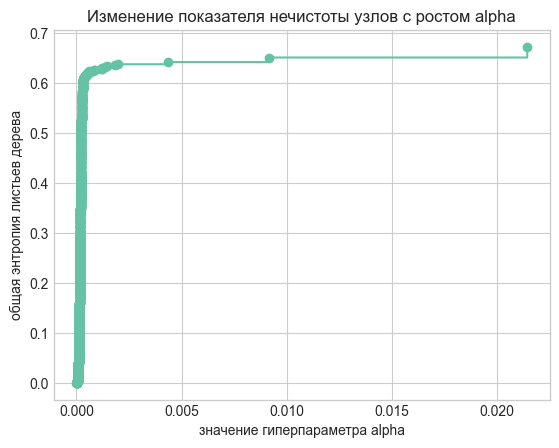

In [27]:
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("значение гиперпараметра alpha")
plt.ylabel("общая энтропия листьев дерева")
plt.title("Изменение показателя нечистоты узлов с ростом alpha")
plt.show()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=my_seed)

clfs = list()

tic = time.perf_counter()

for ccp_alpha in ccp_alphas:
	clf = DecisionTreeClassifier(random_state=my_seed, ccp_alpha=ccp_alpha)
	clf.fit(X_train, y_train)
	clfs.append(clf)

toc = time.perf_counter()
print(f"Расчёты по обрезке дерева заняли {toc - tic:0.2f} секунд")


Расчёты по обрезке дерева заняли 851.91 секунд


In [32]:
tic = time.perf_counter()
node_counts = [clf.tree_.node_count for clf in clfs]
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

toc = time.perf_counter()
print(f"Расчёты показателей точности заняли {toc - tic:0.2f} секунд")

Расчёты показателей точности заняли 14.58 секунд


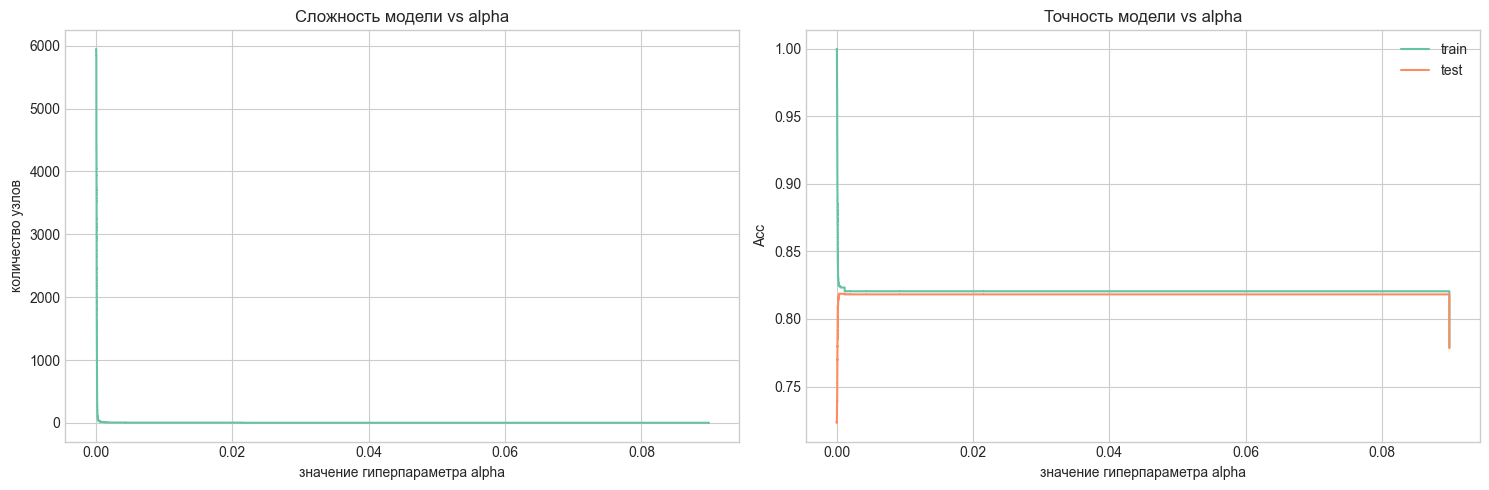

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(ccp_alphas, node_counts, marker=',', drawstyle="steps-post")
ax[0].set_xlabel("значение гиперпараметра alpha")
ax[0].set_ylabel("количество узлов")
ax[0].set_title("Сложность модели vs alpha")

ax[1].plot(ccp_alphas, train_scores, marker=',', label='train', drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores, marker=',', label='test', drawstyle="steps-post")
ax[1].set_xlabel("значение гиперпараметра alpha")
ax[1].set_ylabel("Acc")
ax[1].set_title("Точность модели vs alpha")
ax[1].legend()
fig.tight_layout()

In [34]:
opt_nodes_num = node_counts[test_scores.index(max(test_scores))]

cv = cross_val_score(estimator=clfs[opt_nodes_num], X=X, y=y, cv=5, scoring='accuracy')
score.append(np.around(np.mean(cv), 3))
score_models.append('pruned_tree')
print('Оптимальное количество узлов:', opt_nodes_num, '\nсоответствующая Acc на тестовой:', np.around(max(test_scores), 3), '\n\nAcc с перекрёстной проверкой', '\nдля модели', score_models[1], ':', score[1])

Оптимальное количество узлов: 35 
соответствующая Acc на тестовой: 0.819 

Acc с перекрёстной проверкой 
для модели pruned_tree : 0.741


In [35]:
clfs[opt_nodes_num].get_n_leaves()

np.int64(2110)

In [36]:
clfs[opt_nodes_num].get_depth()

37

In [39]:
[i for i in node_counts if i < 20]

[19, 19, 19, 15, 15, 15, 9, 9, 9, 9, 9, 9, 7, 7, 5, 5, 3, 1]

Количество узлов: 9 
Точность дерева на тестовой: 0.818


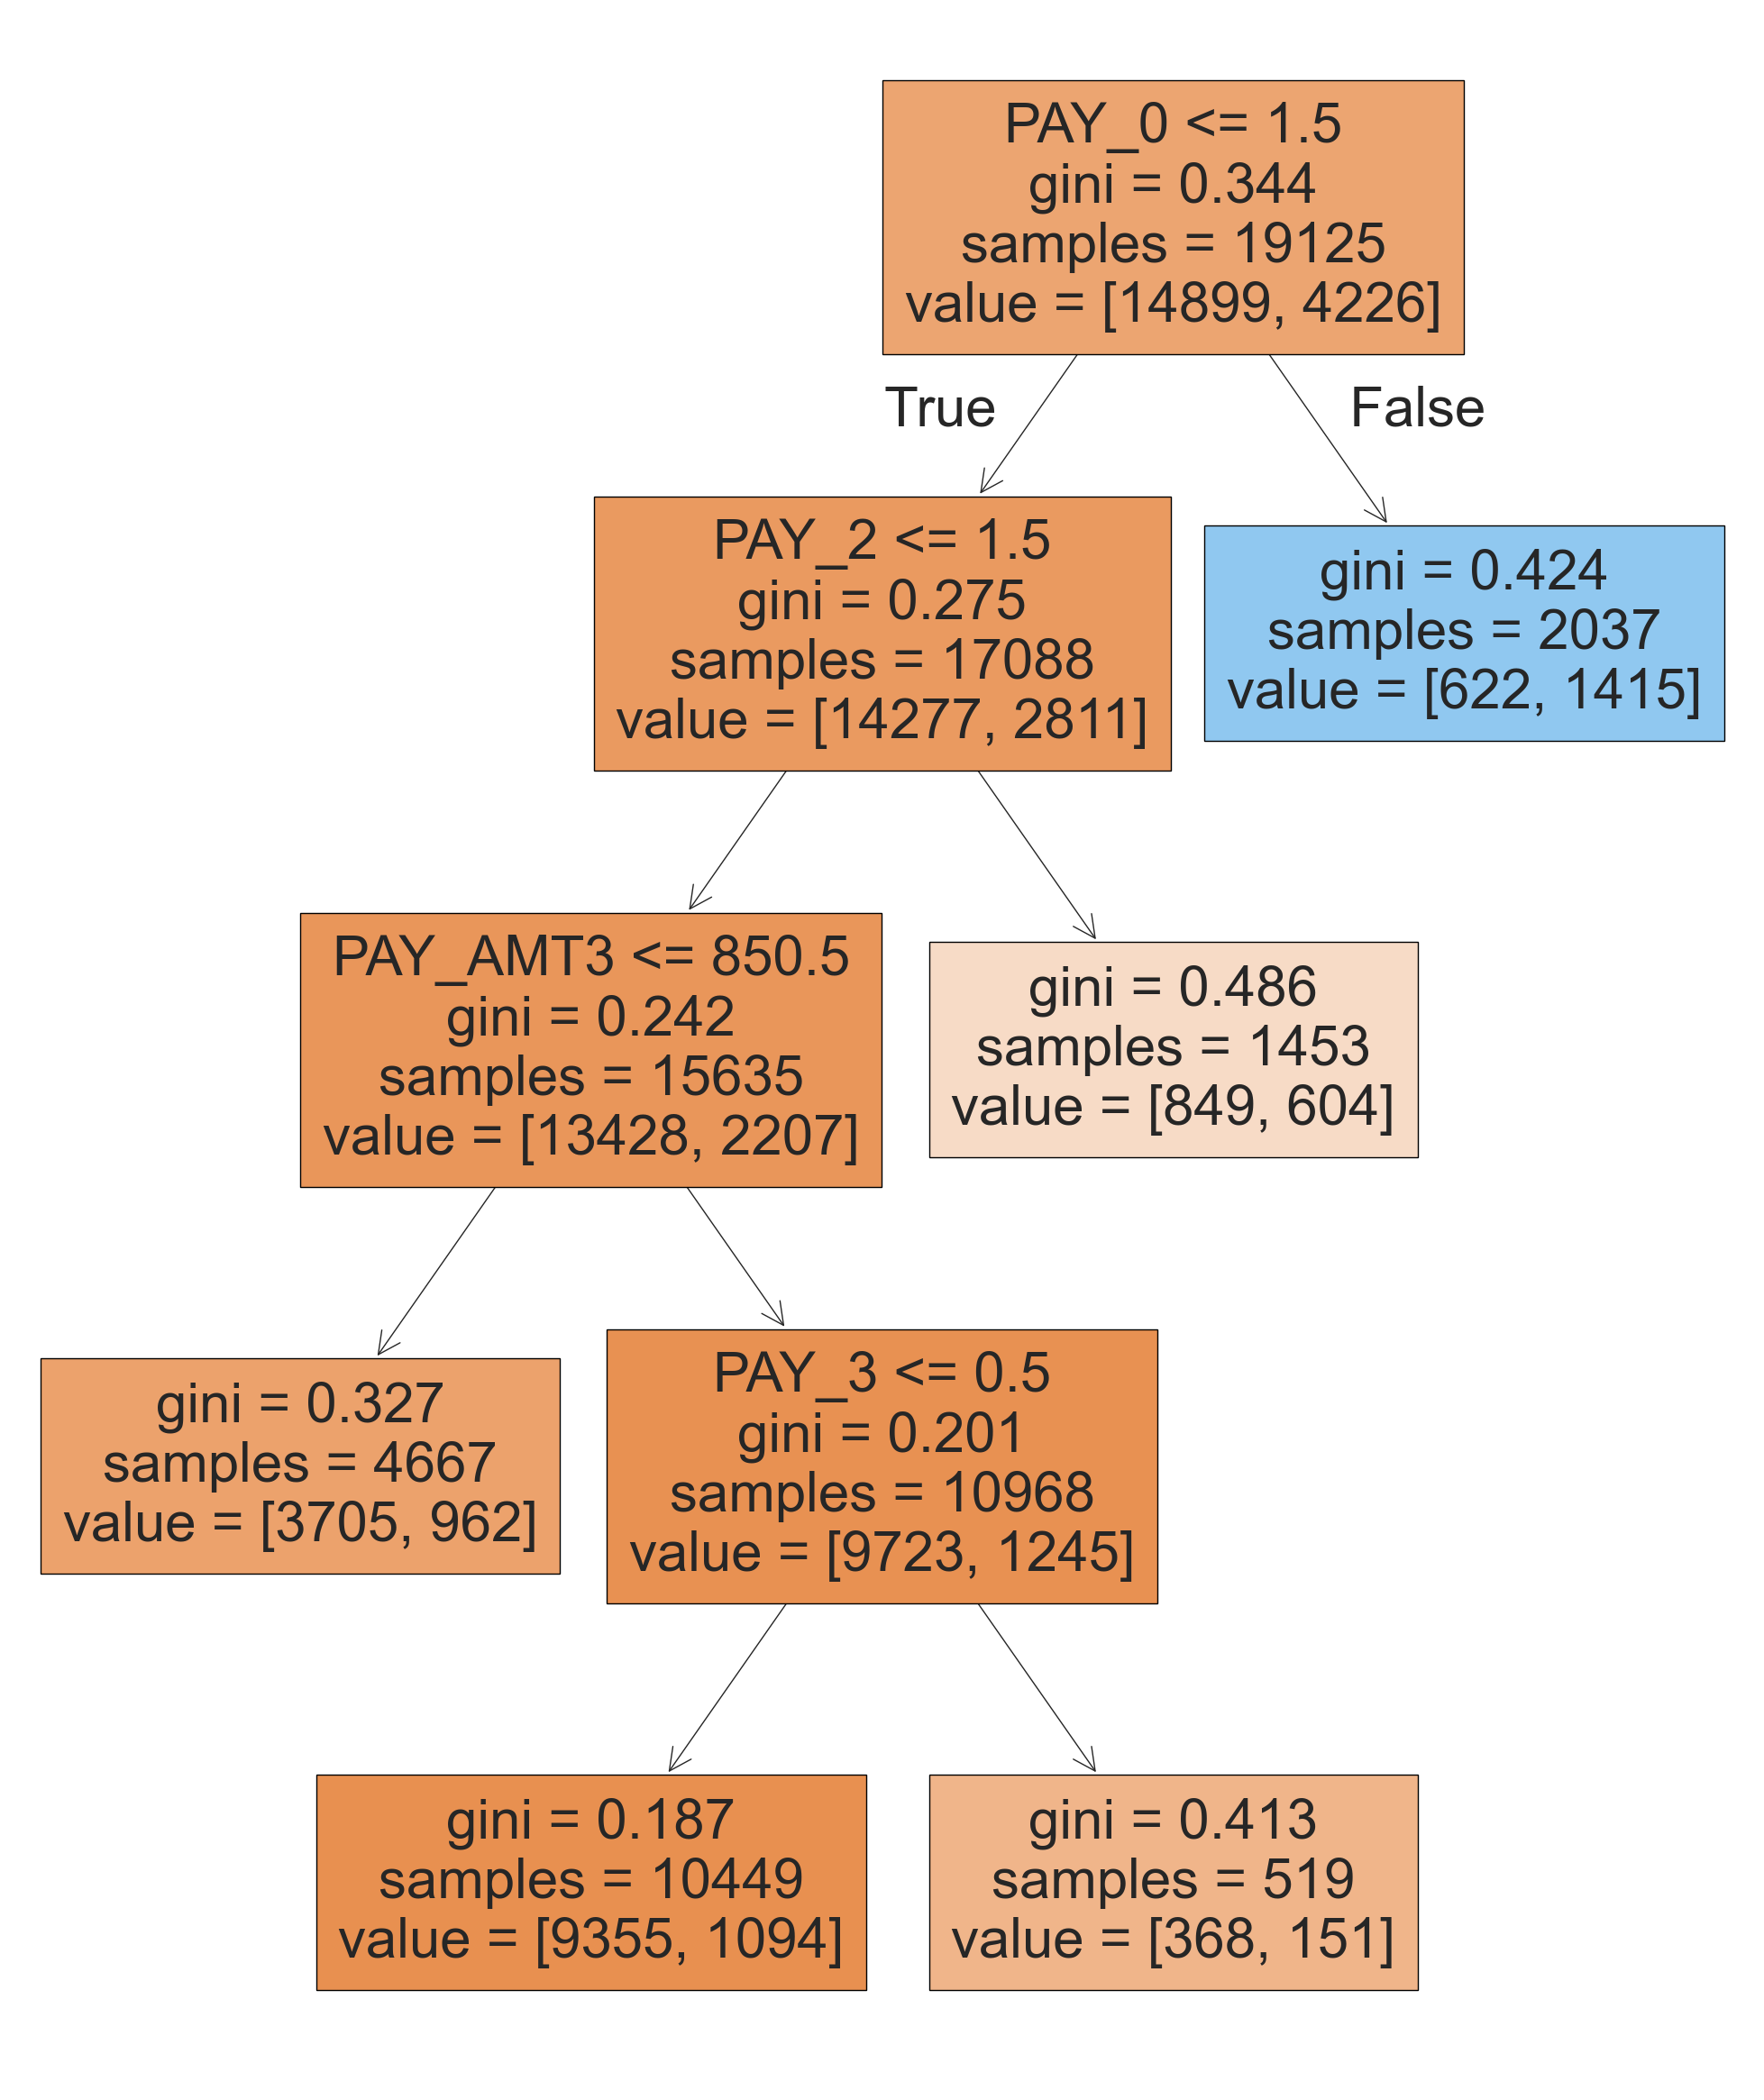

In [46]:
nodes_num = 9
print('Количество узлов:', nodes_num, '\nТочность дерева на тестовой:', np.around(test_scores[node_counts.index(nodes_num)], 3))
fig = plt.figure(figsize=(25,30))
_ = plot_tree(clfs[node_counts.index(nodes_num)], filled=True, feature_names=X.columns)

In [47]:
viz = export_text(clfs[node_counts.index(nodes_num)], feature_names=list(X.columns))
print(viz)

|--- PAY_0 <= 1.50
|   |--- PAY_2 <= 1.50
|   |   |--- PAY_AMT3 <= 850.50
|   |   |   |--- class: 0
|   |   |--- PAY_AMT3 >  850.50
|   |   |   |--- PAY_3 <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- PAY_3 >  0.50
|   |   |   |   |--- class: 0
|   |--- PAY_2 >  1.50
|   |   |--- class: 0
|--- PAY_0 >  1.50
|   |--- class: 1



## Бустинг

In [49]:
kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)
clf_tst = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=my_seed)
cv = cross_val_score(clf_tst, X, y, cv=kfold, scoring='accuracy')
np.around(np.mean(cv), 3)


np.float64(0.819)

In [50]:
param_grid = {'n_estimators' : [10, 20, 30, 40, 50], 'learning_rate' : np.linspace(start=0.01, stop=0.25, num=15), 'max_depth' : [1, 2]}

tic = time.perf_counter()
clf = GridSearchCV(GradientBoostingClassifier(), param_grid, scoring='accuracy', cv=kfold)
boost_tree = clf.fit(X, y)

toc = time.perf_counter()
print(f"Сеточный поиск занял {toc - tic:0.2f} секунд", sep='')


Сеточный поиск занял 1020.06 секунд


In [51]:
np.around(boost_tree.best_score_, 3)

np.float64(0.823)

In [52]:
print('n_estimators:', boost_tree.best_estimator_.get_params()['n_estimators'], '\nlearning_rate:', boost_tree.best_estimator_.get_params()['learning_rate'], '\nmax_depth:', boost_tree.best_estimator_.get_params()['max_depth'])

n_estimators: 30 
learning_rate: 0.13 
max_depth: 2


In [55]:
score.append(np.around(boost_tree.best_score_, 3))
score_models.append('boost_tree_GS')
print('Acc с перекрёстной проверкой для модели', score_models[2], ':', score[2])


Acc с перекрёстной проверкой для модели boost_tree_GS : 0.823


## Прогноз на отложенные наблюдения по лучшей модели

In [56]:
pd.DataFrame({'Модель' : score_models, 'Acc' : score})

,Модель,Acc
0,one_tree,0.725
1,pruned_tree,0.741
2,boost_tree_GS,0.823
3,boost_tree_GS,0.823
4,boost_tree_GS,0.823


Самой точной оказалась Бустинг модель. Сделаем прогноз по отложенным наблюдениям. 

In [57]:
# данные для прогноза
X_pred = DF_predict_num.drop(['index', 'Y'], axis=1)
# строим прогноз
y_hat = boost_tree.best_estimator_.predict(X_pred)
# характеристики точности
print(classification_report(DF_predict_num['Y'], y_hat))


              precision    recall  f1-score   support

           0       0.84      0.95      0.89      3503
           1       0.68      0.35      0.46       997

    accuracy                           0.82      4500
   macro avg       0.76      0.65      0.67      4500
weighted avg       0.80      0.82      0.80      4500

